In [27]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier,RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


from sklearn.metrics import classification_report, roc_auc_score, roc_curve



In [28]:
df = pd.read_csv('data/processed_loan_data.csv')

In [29]:
loanstatus_0 = df[df["default_flag"]==0]
loanstatus_1 = df[df["default_flag"]==1]
subset_of_loanstatus_0 = loanstatus_0.sample(n=55000)
subset_of_loanstatus_1 = loanstatus_1.sample(n=55000)
dataset = pd.concat([subset_of_loanstatus_1, subset_of_loanstatus_0])
dataset = dataset.sample(frac=1).reset_index(drop=True)
print("Current shape of dataset :",dataset.shape)
dataset.head()


Current shape of dataset : (110000, 26)


,loan_amnt,term,int_rate,installment,grade,sub_grade,purpose,annual_inc,emp_length,home_ownership,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,tot_cur_bal,total_rev_hi_lim,funded_amnt,default_flag
0,10000.0,36,5.32,301.15,1,1,2,50000.0,10.0,1,...,11.0,0.0,6147.0,13.7,18.0,0.0,248631.0,44900.0,10000.0,0
1,6000.0,36,8.99,190.78,2,6,9,120000.0,10.0,1,...,15.0,0.0,37495.0,78.1,22.0,0.0,290391.0,48000.0,6000.0,0
2,14575.0,60,16.01,354.52,3,15,4,36000.0,6.0,4,...,15.0,0.0,7982.0,10.8,18.0,0.0,28885.0,73700.0,14575.0,1
3,6000.0,36,16.29,211.81,3,15,2,115000.0,1.0,1,...,9.0,0.0,5696.0,82.6,15.0,0.0,80231.0,24100.0,6000.0,0
4,16000.0,36,9.99,516.20,2,8,2,150000.0,10.0,5,...,8.0,0.0,19265.0,80.6,15.0,0.0,24930.0,23900.0,16000.0,0


In [30]:
feature_cols = [col for col in dataset.columns 
                if col not in ['loan_status', 'default_flag', 'funded_amnt']]

X = dataset[feature_cols]
y = dataset['default_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

=================================================================
#### SECTION 1: TESTING OPTIONS & EVALUATION METRICS
=================================================================


In [31]:

# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'
#scoring ='precision'
#scoring ='recall'
#scoring = 'roc_auc'

#### LOAD CLASSIFICATION MODELS

In [32]:

models = []
models.append(('LR', Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(max_iter=1000, solver='lbfgs'))])))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', Pipeline([('scaler', StandardScaler()), ('model', KNeighborsClassifier())])))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

#Neural Network
models.append(('NN', Pipeline([('scaler', StandardScaler()), ('model', MLPClassifier(max_iter=500, early_stopping=True, random_state=seed))])))

#Ensemble Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))
# XGBoost
models.append(('XGB', XGBClassifier()))

#### K-FOLDS CROSS VALIDATION

In [33]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.650011 (0.004193)
LDA: 0.650307 (0.004408)
KNN: 0.608773 (0.005843)
CART: 0.566989 (0.004374)
NB: 0.629557 (0.004320)
NN: 0.654114 (0.003126)
AB: 0.647159 (0.003739)
GBM: 0.654648 (0.004536)
RF: 0.645807 (0.003408)
ET: 0.642080 (0.004720)
XGB: 0.648807 (0.005100)


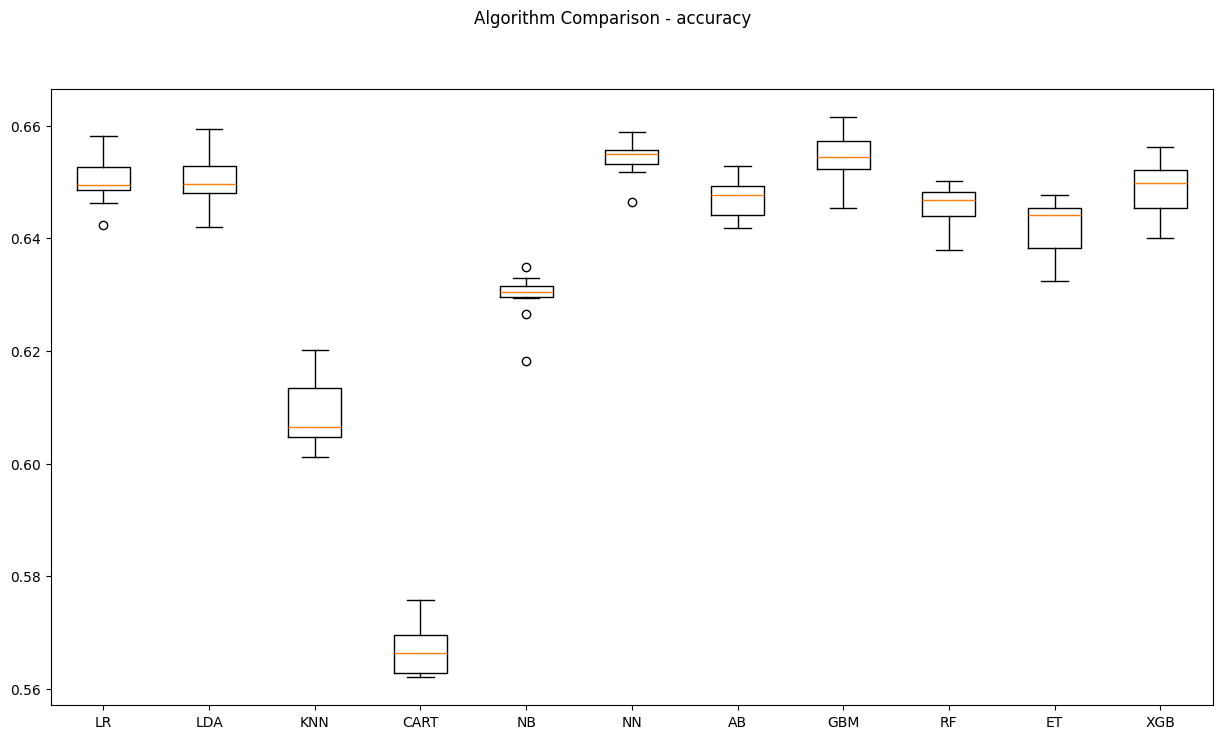

In [34]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison'+ ' - ' + scoring)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()